In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string

import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import MWETokenizer
from nltk.stem.lancaster import LancasterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from gensim import corpora,models,matutils
from scipy import sparse

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, plot_roc_curve, roc_curve

In [2]:
#load in stack overflow data w condescension labels
stack_overflow_df = pd.read_csv('/Users/amelialui/Desktop/DS_Projects/Condescension_Detection_Stack_Overflow/dataCompleted.csv')
stack_overflow_df = stack_overflow_df.drop(columns=['Unnamed: 0'])


# Text Preprocessing, Tokenization

In [3]:
stack_overflow_df.head()

,text,c_label
0,"Yeah, I didn't believe it until I created a co...",False
1,It will help if you give some details of which...,False
2,infact it does. Look a the first lines of your...,False
3,"""Currently + is implemented using StringBuffer...",False
4,That code will fail as .Distinct() returns an ...,False


In [4]:
stack_overflow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3887 entries, 0 to 3886
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     3887 non-null   object
 1   c_label  3887 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 34.3+ KB


want to make a third column, stack_overflow_df['sentiment']

In [5]:
analyzer = SentimentIntensityAnalyzer()
negative_scores = [] #we care more about how negative it is, not how neutral or pos or overall

for i in range(0,3887):
    doc = stack_overflow_df['text'][i]
    sentiment = analyzer.polarity_scores(doc)
    neg = sentiment['neg']
    negative_scores.append(neg)

stack_overflow_df['neg_sentiment'] = negative_scores

In [6]:
stack_overflow_df.head()

,text,c_label,neg_sentiment
0,"Yeah, I didn't believe it until I created a co...",False,0.127
1,It will help if you give some details of which...,False,0.000
2,infact it does. Look a the first lines of your...,False,0.105
3,"""Currently + is implemented using StringBuffer...",False,0.000
4,That code will fail as .Distinct() returns an ...,False,0.189


In [7]:
#remove stop words
def split(word):
    return [char for char in word]
punc = split(string.punctuation)
stop_words = set(stopwords.words('english'))

for i in range(0,3887):
    doc = stack_overflow_df['text'][i]
    filtered = [w for w in word_tokenize(doc) if not w.lower() in stop_words]
    filtered = [w for w in word_tokenize(" ".join(filtered)) if not w.lower() in punc]
    stack_overflow_df.at[i, 'text'] = " ".join(filtered)

stack_overflow_df.head()

,text,c_label,neg_sentiment
0,Yeah n't believe created console app good lord...,False,0.127
1,help give details database using techniques vary,False,0.000
2,infact Look first lines concat code problem co...,False,0.105
3,`` Currently implemented using StringBuffer ``...,False,0.000
4,code fail .Distinct returns IEnumerable add .T...,False,0.189


In [8]:
#get rid of numbers
for i in range(0,3887):
    doc = stack_overflow_df['text'][i]
    doc_no_nums = re.sub("\d+", " ", doc)
    stack_overflow_df.at[i, 'text'] = doc_no_nums

In [9]:
#simplify terms down to their stems
#stemmer = LancasterStemmer()

#for i in range(0,3887):
    #doc = stack_overflow_df['text'][i]
    #filtered = ""
    #for word in doc.split():
        #stem = stemmer.stem(word)
        #filtered += stem + " "
    #filtered.rstrip()
    #stack_overflow_df.at[i, 'text'] = filtered.lower()

compound term extraction for emotes like :)

In [10]:
mwe_tokenizer = MWETokenizer([(':',')'), (';',')'),(':','('), ('=',')'),('=','('),
                              (':','-',')'), (':','-','('),
                              (':',"'",'-','('),('X','D'),(':','D'),(':',']'),
                              ('>',':','('),('>',':','['),
                              (':','/'),(':','|'),
                              ('<','_','<'),('>','_','>'),('o','_','o'),('O','_','O')])

for i in range(0,3886):
    doc = stack_overflow_df['text'][i]
    mwe_tokens = mwe_tokenizer.tokenize(word_tokenize(doc))
    
#make tokenizer that combines mwe_tokenizer and word_tokenizer to make callable
def my_tokenizer(text):
    mwe_tokens = mwe_tokenizer.tokenize(word_tokenize(text))
    return(mwe_tokens)

print(my_tokenizer(stack_overflow_df['text'][0]))

['Yeah', "n't", 'believe', 'created', 'console', 'app', 'good', 'lord', 'would', 'give', 'rope', 'hang', 'hated', 'VB.NET', 'OrElse', 'AndAlso', 'keywords']


# Make CountVectorizer Doc-Term Matrix

In [11]:
cv = CountVectorizer(tokenizer = my_tokenizer)
cv_X = cv.fit_transform(stack_overflow_df['text'])
cv_doc_term_mat = pd.DataFrame(cv_X.toarray(), columns = cv.get_feature_names_out())
cv_doc_term_mat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3887 entries, 0 to 3886
Columns: 9625 entries, ' to …
dtypes: int64(9625)
memory usage: 285.4 MB


In [12]:
cv_doc_term_mat.values.sum()
#looks about right

55910

In [13]:
cv_doc_term_mat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3887 entries, 0 to 3886
Columns: 9625 entries, ' to …
dtypes: int64(9625)
memory usage: 285.4 MB


# Make TF-IDF Doc-Term Matrix

In [14]:
tfidf = TfidfVectorizer(tokenizer = my_tokenizer)
tfidf_X = tfidf.fit_transform(stack_overflow_df['text'])
tfidf_doc_term_mat = pd.DataFrame(tfidf_X.toarray(), columns = tfidf.get_feature_names_out())
tfidf_doc_term_mat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3887 entries, 0 to 3886
Columns: 9625 entries, ' to …
dtypes: float64(9625)
memory usage: 285.4 MB


# Latent Semantic Analysis Model

w/ count vectorizer

In [15]:
lsa = TruncatedSVD(3)
lsa.fit(cv_doc_term_mat)

TruncatedSVD(n_components=3)

In [16]:
def topics(model, feature_names, top_words, topic_names=None):
    for j, topic in enumerate(model):
        if not topic_names or not topic_names[j]:
            print("\nTopic ")
        else:
            print("\nTopic:",topic_names[j])
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-top_words - 1:-1]]))

In [17]:
topics(lsa.components_, cv_doc_term_mat.columns, 20, topic_names=['asking for clarification','technical','reviews on other comments'])



Topic: asking for clarification
``, n't, 's, use, code, would, ..., one, like, answer, also, question, c, object, ., get, way, think, using, need

Topic: technical
``, cast, ~, derived, straight, postgresql, exact, var, printf, typeof, derives, student, .constructor, computer, insane, controlchars.quote, repeating, intend, -name, namespacelist

Topic: reviews on other comments
's, code, way, think, like, answer, function, much, data, language, also, right, problem, http, around, wrong, goto, since, pretty, lot


this model makes sense, but it was a bit of a stretch to define the topics.

# Latent Semantic Analysis Model
w/ tfidf

In [18]:
lsa = TruncatedSVD(3)
lsa.fit(tfidf_doc_term_mat)

TruncatedSVD(n_components=3)

In [19]:
topics(lsa.components_, tfidf_doc_term_mat.columns, 20, topic_names=['asking for clarification','technical','reviews on other comments'])



Topic: asking for clarification
``, n't, 's, use, code, would, ..., one, question, answer, like, think, c, also, good, need, really, way, want, using

Topic: technical
``, jpeg, ocaml, postgresql, words, datetime.now.tostring, case-insensitive, -tiers, n-tiers, associative, repeating, commutative, controlchars.quote, foo, hofstadterian, age, href=, insane, cryptography, combining

Topic: reviews on other comments
question, answer, asked, answers, good, asking, valid, ask, c++, perfectly, questions, answered, vote, accepted, nice, different, correct, post, subjective, one


same topics, looks almost same as w countvectorizer input, the last topic makes a lot more sense with this group of words

# Non-Negative Matrix Factorization
w/ cv

In [20]:
nmf = NMF(3)
nmf.fit(cv_doc_term_mat)

/Users/amelialui/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


NMF(n_components=3)

In [21]:
topics(nmf.components_, cv_doc_term_mat.columns, 20, topic_names=["technical","asking for clarification","reviews on other comments"])



Topic: technical
``, string, cast, object, new, use, ..., ., also, name, like, x, would, type, instead, different, one, ==, example, code

Topic: asking for clarification
n't, would, use, ca, code, one, ..., want, question, could, c, work, like, think, answer, need, time, know, make, using

Topic: reviews on other comments
's, code, think, use, like, answer, way, one, c, good, ..., question, time, would, also, using, function, know, much, need


# Non-Negative Matrix Factorization
w/ tfidf

In [22]:
nmf = NMF(3)
nmf.fit(tfidf_doc_term_mat)

/Users/amelialui/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


NMF(n_components=3)

In [23]:
topics(nmf.components_, tfidf_doc_term_mat.columns, 20, topic_names=["technical","asking for clarification","reviews on other comments"])



Topic: technical
``, mean, string, new, also, example, different, best, statement, use, ==, --, ., actually, name, read, work, put, say, get

Topic: asking for clarification
n't, 's, code, use, ..., would, one, think, like, c, need, time, using, way, know, ca, want, could, good, 're

Topic: reviews on other comments
question, answer, asked, good, one, answers, would, asking, valid, c++, ask, vote, perfectly, accepted, nice, answered, questions, different, people, think


# Add LSA TFIDF Model to DF
This model made most sense overall

In [24]:
lsa.transform(tfidf_doc_term_mat).tolist()

[[0.04185612157516906, -0.08850437172698633, -0.004839773810875579],
 [0.02358291198589463, -0.046590073820414905, -0.002936018954458795],
 [0.044888548086182985, -0.06546244256663718, -0.04179421132617069],
 [0.19601036864510055, 0.04668949021073287, -0.011794694893860407],
 [0.026784441856634422, -0.04811177732899725, -0.0404578951152731],
 [0.0861905696385305, -0.17927835851352555, -0.030394116012717666],
 [0.06788642449593546, -0.13559370365741752, -0.04885534982156884],
 [0.6341389710359764, 0.3007540642650205, 0.008780588362160053],
 [0.04785942210109899, -0.09475636812354223, -0.0035501771951569365],
 [0.04785942210109899, -0.09475636812354223, -0.0035501771951569365],
 [0.028862470620396798, -0.04555585927463099, -0.022592568261938572],
 [0.04978255045970931, -0.09176240484762474, -0.04448641421031833],
 [0.17003557692573734, 0.05076611471173577, -0.014574520675761402],
 [0.07620240258500274, -0.1282817096775582, -0.08723991112992761],
 [0.022167418512821415, -0.039782198624813

In [25]:
topic1 = []
topic2 = []
topic3 = []
for topic_list in lsa.transform(tfidf_doc_term_mat).tolist():
    topic1.append(topic_list[0])
    topic2.append(topic_list[1])
    topic3.append(topic_list[2])

In [26]:
stack_overflow_df['topic1'] = topic1
stack_overflow_df['topic2'] = topic2
stack_overflow_df['topic3'] = topic3

In [27]:
stack_overflow_df.head()

,text,c_label,neg_sentiment,topic1,topic2,topic3
0,Yeah n't believe created console app good lord...,False,0.127,0.041856,-0.088504,-0.004840
1,help give details database using techniques vary,False,0.000,0.023583,-0.046590,-0.002936
2,infact Look first lines concat code problem co...,False,0.105,0.044889,-0.065462,-0.041794
3,`` Currently implemented using StringBuffer ``...,False,0.000,0.196010,0.046689,-0.011795
4,code fail .Distinct returns IEnumerable add .T...,False,0.189,0.026784,-0.048112,-0.040458


# EDA for Classification

In [28]:
stack_overflow_df["c_label"] = stack_overflow_df["c_label"].astype(int)

X = stack_overflow_df[['neg_sentiment','topic1','topic2','topic3']]
y = stack_overflow_df.c_label


<AxesSubplot:xlabel='c_label', ylabel='neg_sentiment'>

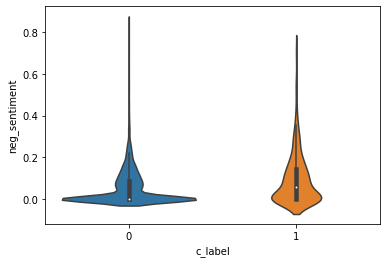

In [29]:
sns.violinplot(x=stack_overflow_df["c_label"],y=stack_overflow_df["neg_sentiment"])

<AxesSubplot:xlabel='c_label', ylabel='topic1'>

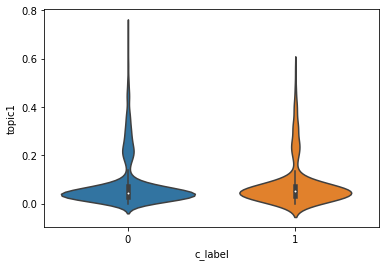

In [30]:
sns.violinplot(x=stack_overflow_df["c_label"],y=stack_overflow_df["topic1"])

<AxesSubplot:xlabel='c_label', ylabel='topic2'>

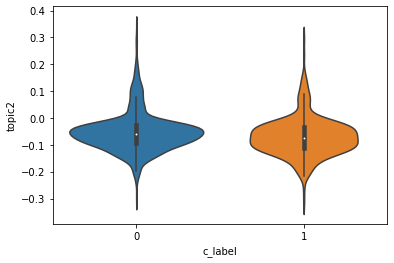

In [31]:
sns.violinplot(x=stack_overflow_df["c_label"],y=stack_overflow_df["topic2"])

<AxesSubplot:xlabel='c_label', ylabel='topic3'>

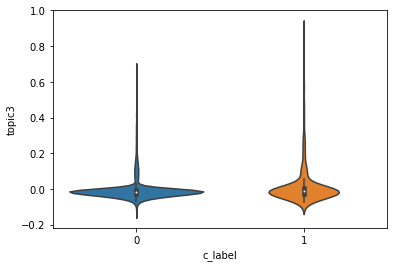

In [32]:
sns.violinplot(x=stack_overflow_df["c_label"],y=stack_overflow_df["topic3"])

# Split data

In [33]:
#Split the data into train and test sets (80/20) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=8)
df_train = X_train
df_train['c_label'] = y_train

# Resample data since unbalanced

In [34]:
df_majority = df_train[(df_train['c_label']==0)] 
df_minority = df_train[(df_train['c_label']==1)] 
# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 131177, # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])

X_train_upsampled = df_upsampled[['neg_sentiment','topic1','topic2','topic3']]
y_train_upsampled = df_upsampled['c_label']

# Scale Data

In [35]:
#scale data for knn and logreg
std_scale = StandardScaler()

X_train_scaled_upsampled = std_scale.fit_transform(X_train_upsampled)
X_test_scaled = std_scale.transform(X_test)

# kNN

In [36]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled_upsampled, y_train_upsampled)
y_pred_knn = knn.predict(X_test_scaled)

print("Model: kNN\n")
print("accuracy score:", "{0:.2%}".format(accuracy_score(y_test, y_pred_knn)))
print("precision score:", "{0:.2%}".format(precision_score(y_test, y_pred_knn)))
print("recall score:", "{0:.2%}".format(recall_score(y_test, y_pred_knn)))
print("f1 score:", "{0:.2%}".format(f1_score(y_test, y_pred_knn)))

Model: kNN

accuracy score: 75.96%
precision score: 17.31%
recall score: 31.76%
f1 score: 22.41%


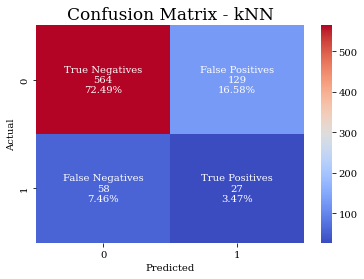

In [37]:
cm = confusion_matrix(y_test, y_pred_knn)

plt.rcParams['font.family'] = "serif"

names = ["True Negatives","False Positives","False Negatives","True Positives"]
counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
percents = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percents)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt="", cmap='coolwarm');
plt.title("Confusion Matrix - kNN",fontsize=17)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [71]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled_upsampled, y_train_upsampled)
y_pred_knn = (knn.predict_proba(X_test_scaled)[:,1] >= 0.3).astype(bool)

print("Model: kNN with lower decision threshold\n")
print("accuracy score:", "{0:.2%}".format(accuracy_score(y_test, y_pred_knn)))
print("precision score:", "{0:.2%}".format(precision_score(y_test, y_pred_knn)))
print("recall score:", "{0:.2%}".format(recall_score(y_test, y_pred_knn)))
print("f1 score:", "{0:.2%}".format(f1_score(y_test, y_pred_knn)))

Model: kNN with lower decision threshold

accuracy score: 70.18%
precision score: 16.13%
recall score: 41.18%
f1 score: 23.18%


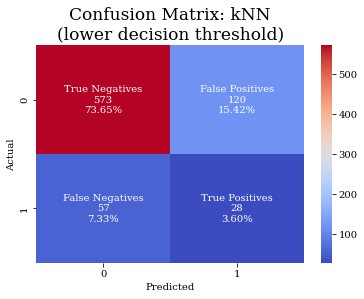

In [68]:
cm = confusion_matrix(y_test, y_pred_knn)

plt.rcParams['font.family'] = "serif"

names = ["True Negatives","False Positives","False Negatives","True Positives"]
counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
percents = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percents)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt="", cmap='coolwarm');
plt.title("Confusion Matrix: kNN\n(lower decision threshold)",fontsize=17)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# LogReg

In [40]:
#instantiate, then fit
logreg = LogisticRegression()
logreg.fit(X_train_scaled_upsampled, y_train_upsampled)

#prediction
p_pred = logreg.predict_proba(X_test_scaled)[:,1]
y_pred = np.where(p_pred > 0.5, 1, 0)

In [41]:
print("Model: LogReg\n")

print("accuracy score:", "{0:.2%}".format(accuracy_score(y_test, y_pred)))
print("precision score:", "{0:.2%}".format(precision_score(y_test, y_pred)))
print("recall score:", "{0:.2%}".format(recall_score(y_test, y_pred)))
print("f1 score:", "{0:.2%}".format(f1_score(y_test, y_pred)))

Model: LogReg

accuracy score: 10.93%
precision score: 10.93%
recall score: 100.00%
f1 score: 19.70%


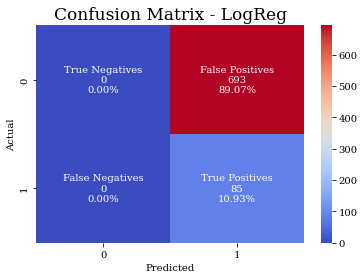

In [42]:
cm = confusion_matrix(y_test, y_pred)

plt.rcParams['font.family'] = "serif"

names = ["True Negatives","False Positives","False Negatives","True Positives"]
counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
percents = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percents)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt="", cmap='coolwarm');
plt.title("Confusion Matrix - LogReg",fontsize=17)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

neg_sentiment : 0.5225111925864416
topic1 : 0.11804928185152197
topic2 : -0.31990213067935275
topic3 : 0.3430449306871736


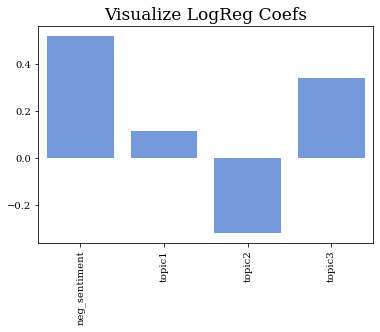

In [43]:
#visualize coefs
features = []
coefs = []

plt.rcParams['font.family'] = "serif"

i=0
while i < (len(list(X.columns.values))):
    features.append(X.columns.values[i])
    coefs.append(logreg.coef_[0][i])
    print(X.columns.values[i], ":", logreg.coef_[0][i])
    i+=1
    
sns.barplot(x=features,y=coefs,color='cornflowerblue')
plt.xticks(rotation=90)
plt.title("Visualize LogReg Coefs",fontsize = 17)
plt.show()

In [70]:
#instantiate, then fit
logreg = LogisticRegression()
logreg.fit(X_train_scaled_upsampled, y_train_upsampled)

#prediction
y_pred = (logreg.predict_proba(X_test_scaled)[:,1] >= 0.3).astype(bool)

print("Model: LogReg with lower decision threshold\n")
print("accuracy score:", "{0:.2%}".format(accuracy_score(y_test, y_pred)))
print("precision score:", "{0:.2%}".format(precision_score(y_test, y_pred)))
print("recall score:", "{0:.2%}".format(recall_score(y_test, y_pred)))
print("f1 score:", "{0:.2%}".format(f1_score(y_test, y_pred)))

Model: LogReg with lower decision threshold

accuracy score: 10.93%
precision score: 10.93%
recall score: 100.00%
f1 score: 19.70%


so much for logistic regression >:(

# Random Forests

In [44]:
#instantiate, then fit
rf = RandomForestClassifier()
rf.fit(X_train_upsampled, y_train_upsampled)
y_pred = rf.predict(X_test)

In [45]:
print("Model: Random Forests\n")

print("accuracy score:", "{0:.2%}".format(accuracy_score(y_test, y_pred)))
print("precision score:", "{0:.2%}".format(precision_score(y_test, y_pred)))
print("recall score:", "{0:.2%}".format(recall_score(y_test, y_pred)))
print("f1 score:", "{0:.2%}".format(f1_score(y_test, y_pred)))

Model: Random Forests

accuracy score: 85.99%
precision score: 12.50%
recall score: 4.71%
f1 score: 6.84%


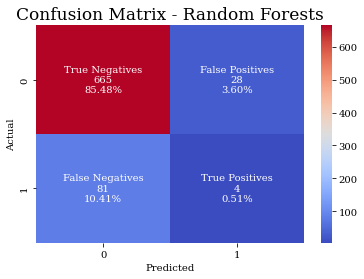

In [46]:
cm = confusion_matrix(y_test, y_pred)

plt.rcParams['font.family'] = "serif"

names = ["True Negatives","False Positives","False Negatives","True Positives"]
counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
percents = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percents)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt="", cmap='coolwarm');
plt.title("Confusion Matrix - Random Forests",fontsize=17)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [72]:
#instantiate, then fit
rf = RandomForestClassifier()
rf.fit(X_train_upsampled, y_train_upsampled)
y_pred = (rf.predict_proba(X_test_scaled)[:,1] >= 0.3).astype(bool)

/Users/amelialui/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [74]:
print("Model: Random Forests with lower decision threshold\n")

print("accuracy score:", "{0:.2%}".format(accuracy_score(y_test, y_pred)))
print("precision score:", "{0:.2%}".format(precision_score(y_test, y_pred)))
print("recall score:", "{0:.2%}".format(recall_score(y_test, y_pred)))
print("f1 score:", "{0:.2%}".format(f1_score(y_test, y_pred)))

Model: Random Forests with lower decision threshold

accuracy score: 88.56%
precision score: 16.67%
recall score: 1.18%
f1 score: 2.20%
